In [71]:
from pathlib import Path
import pandas as pd

def load_uidai_folder(folder_path):
    files = list(Path(folder_path).glob("*.csv"))
    print(f"Found {len(files)} files in {folder_path}")
    
    df = pd.concat(
        (pd.read_csv(f) for f in files),
        ignore_index=True
    )
    return df


In [72]:
BASE_PATH = "../data"

enrolment_df = load_uidai_folder(f"{BASE_PATH}/api_data_aadhar_enrolment")
demo_df      = load_uidai_folder(f"{BASE_PATH}/api_data_aadhar_demographic")
bio_df       = load_uidai_folder(f"{BASE_PATH}/api_data_aadhar_biometric")

Found 3 files in ../data/api_data_aadhar_enrolment
Found 5 files in ../data/api_data_aadhar_demographic
Found 4 files in ../data/api_data_aadhar_biometric


In [73]:
def basic_sanity(df, name):
    print(f"\n{name} SHAPE:", df.shape)
    print("COLUMNS:", list(df.columns))
    print("\nNULL COUNT:")
    print(df.isnull().sum())

In [74]:
basic_sanity(enrolment_df, "ENROLMENT")
basic_sanity(demo_df, "DEMOGRAPHIC")
basic_sanity(bio_df, "BIOMETRIC")


ENROLMENT SHAPE: (1006029, 7)
COLUMNS: ['date', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17', 'age_18_greater']

NULL COUNT:
date              0
state             0
district          0
pincode           0
age_0_5           0
age_5_17          0
age_18_greater    0
dtype: int64

DEMOGRAPHIC SHAPE: (2071700, 6)
COLUMNS: ['date', 'state', 'district', 'pincode', 'demo_age_5_17', 'demo_age_17_']

NULL COUNT:
date             0
state            0
district         0
pincode          0
demo_age_5_17    0
demo_age_17_     0
dtype: int64

BIOMETRIC SHAPE: (1861108, 6)
COLUMNS: ['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_']

NULL COUNT:
date            0
state           0
district        0
pincode         0
bio_age_5_17    0
bio_age_17_     0
dtype: int64


In [75]:
def add_year_month(df):
    if not pd.api.types.is_datetime64_any_dtype(df["date"]):
        df["date"] = pd.to_datetime(
            df["date"],
            dayfirst=True,
            errors="raise"
        )
    df["year_month"] = df["date"].dt.to_period("M").astype(str)
    return df

In [76]:
enrolment_df = add_year_month(enrolment_df)
demo_df      = add_year_month(demo_df)
bio_df       = add_year_month(bio_df)


In [77]:
enrolment_df[["date", "year_month"]].head()

,date,year_month
0,2025-03-02,2025-03
1,2025-03-09,2025-03
2,2025-03-09,2025-03
3,2025-03-09,2025-03
4,2025-03-09,2025-03


In [78]:
def aggregate_district_month(df, value_cols):
    return (
        df.groupby(["state", "district", "year_month"])[value_cols]
          .sum()
          .reset_index()
    )

In [79]:
enrolment_signal = aggregate_district_month(
    enrolment_df,
    ["age_0_5", "age_5_17", "age_18_greater"]
)

demo_signal = aggregate_district_month(
    demo_df,
    ["demo_age_5_17", "demo_age_17_"]
)

bio_signal = aggregate_district_month(
    bio_df,
    ["bio_age_5_17", "bio_age_17_"]
)

In [80]:
type(enrolment_signal), type(demo_signal), type(bio_signal)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame)

In [81]:
print("Enrolment:", enrolment_signal.shape)
print("Demographic:", demo_signal.shape)
print("Biometric:", bio_signal.shape)

Enrolment: (5062, 6)
Demographic: (6072, 5)
Biometric: (8507, 5)


In [82]:
import os

os.makedirs("data/processed", exist_ok=True)


In [83]:
enrolment_signal.to_csv(
    "data/processed/enrolment_district_month.csv", index=False
)

demo_signal.to_csv(
    "data/processed/demographic_district_month.csv", index=False
)

bio_signal.to_csv(
    "data/processed/biometric_district_month.csv", index=False
)


In [84]:

# 1. Load the processed files (Clean Start for Logic)
print("Reloading processed data...")
df_enrol = pd.read_csv("data/processed/enrolment_district_month.csv")
df_demo = pd.read_csv("data/processed/demographic_district_month.csv")
df_bio = pd.read_csv("data/processed/biometric_district_month.csv")

# 2. Merge into Master Table
# Merge Enrolment + Demographic
df_master = pd.merge(
    df_enrol, 
    df_demo, 
    on=['state', 'district', 'year_month'], 
    how='outer', 
    suffixes=('_enrol', '_demo')
)

# Merge + Biometric
df_master = pd.merge(
    df_master, 
    df_bio, 
    on=['state', 'district', 'year_month'], 
    how='outer', 
    suffixes=('', '_bio')
)

# Fill NaNs with 0 (Missing data implies 0 updates)
df_master.fillna(0, inplace=True)

print(f"Master Table Shape: {df_master.shape}")
df_master.head(10)

Reloading processed data...
Master Table Shape: (8703, 10)


,state,district,year_month,age_0_5,age_5_17,age_18_greater,demo_age_5_17,demo_age_17_,bio_age_5_17,bio_age_17_
0,100000,100000,2025-09,0.0,0.0,12.0,0.0,0.0,0.0,0.0
1,100000,100000,2025-10,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,100000,100000,2025-11,0.0,0.0,11.0,0.0,0.0,0.0,0.0
3,100000,100000,2025-12,0.0,0.0,194.0,0.0,2.0,0.0,0.0
4,Andaman & Nicobar Islands,Andamans,2025-03,0.0,0.0,0.0,0.0,0.0,16.0,193.0
5,Andaman & Nicobar Islands,Andamans,2025-04,0.0,0.0,0.0,0.0,0.0,17.0,167.0
6,Andaman & Nicobar Islands,Andamans,2025-05,0.0,0.0,0.0,0.0,0.0,22.0,158.0
7,Andaman & Nicobar Islands,Andamans,2025-06,0.0,0.0,0.0,0.0,0.0,11.0,129.0
8,Andaman & Nicobar Islands,Andamans,2025-07,0.0,0.0,0.0,0.0,0.0,20.0,239.0
9,Andaman & Nicobar Islands,Andamans,2025-09,23.0,4.0,0.0,3.0,159.0,76.0,241.0


In [85]:
df_master.isna()

,state,district,year_month,age_0_5,age_5_17,age_18_greater,demo_age_5_17,demo_age_17_,bio_age_5_17,bio_age_17_
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
8698,False,False,False,False,False,False,False,False,False,False
8699,False,False,False,False,False,False,False,False,False,False
8700,False,False,False,False,False,False,False,False,False,False
8701,False,False,False,False,False,False,False,False,False,False


In [86]:
df_master.isna().sum()

state             0
district          0
year_month        0
age_0_5           0
age_5_17          0
age_18_greater    0
demo_age_5_17     0
demo_age_17_      0
bio_age_5_17      0
bio_age_17_       0
dtype: int64

In [87]:
df_master.state.unique()

array(['100000', 'Andaman & Nicobar Islands',
       'Andaman and Nicobar Islands', 'Andhra Pradesh',
       'Arunachal Pradesh', 'Assam', 'BALANAGAR', 'Bihar', 'Chandigarh',
       'Chhatisgarh', 'Chhattisgarh', 'Dadra & Nagar Haveli',
       'Dadra and Nagar Haveli',
       'Dadra and Nagar Haveli and Daman and Diu', 'Daman & Diu',
       'Daman and Diu', 'Darbhanga', 'Delhi', 'Goa', 'Gujarat', 'Haryana',
       'Himachal Pradesh', 'Jaipur', 'Jammu & Kashmir',
       'Jammu And Kashmir', 'Jammu and Kashmir', 'Jharkhand', 'Karnataka',
       'Kerala', 'Ladakh', 'Lakshadweep', 'Madanapalle', 'Madhya Pradesh',
       'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland',
       'Nagpur', 'ODISHA', 'Odisha', 'Orissa', 'Pondicherry',
       'Puducherry', 'Punjab', 'Puttenahalli', 'Raja Annamalai Puram',
       'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Tamilnadu', 'Telangana',
       'The Dadra And Nagar Haveli And Daman And Diu', 'Tripura',
       'Uttar Pradesh', 'Uttarakhand', 'Uttar

In [88]:
import pandas as pd

# 1. Remove Garbage
df_master = df_master[df_master['state'].astype(str) != '100000']

# 2. Standardize Text (Strip & Title Case)
df_master['state'] = df_master['state'].astype(str).str.strip().str.title()

# 3. Fix Redundancies (Updated with your latest output)
corrections = {
    # WEST BENGAL FIXES 
    'West Bengli': 'West Bengal',
    'Westbengal': 'West Bengal',
    'Wb': 'West Bengal',
    'West Bangal': 'West Bengal',   
    'West  Bengal': 'West Bengal',  
    
    # DADRA & DAMAN FIXES 
    'Dadra And Nagar Haveli': 'Dadra and Nagar Haveli and Daman and Diu',
    'Dadra & Nagar Haveli': 'Dadra and Nagar Haveli and Daman and Diu', 
    'Daman And Diu': 'Dadra and Nagar Haveli and Daman and Diu',
    'Daman & Diu': 'Dadra and Nagar Haveli and Daman and Diu',    
    'The Dadra And Nagar Haveli And Daman And Diu': 'Dadra and Nagar Haveli and Daman and Diu',
    'Dadra And Nagar Haveli And Daman And Diu': 'Dadra and Nagar Haveli and Daman and Diu',

    # OTHER SPELLING FIXES 
    'Chhatisgarh': 'Chhattisgarh',
    'Orissa': 'Odisha',
    'Pondicherry': 'Puducherry',
    'Tamilnadu': 'Tamil Nadu',
    'Uttaranchal': 'Uttarakhand',
    'Jammu And Kashmir': 'Jammu & Kashmir',
    'Andaman And Nicobar Islands': 'Andaman & Nicobar Islands',

    # CITY MAPPING FIXES 
    'Balanagar': 'Telangana',
    'Darbhanga': 'Bihar',
    'Jaipur': 'Rajasthan',
    'Madanapalle': 'Andhra Pradesh',
    'Nagpur': 'Maharashtra',
    'Puttenahalli': 'Karnataka',
    'Raja Annamalai Puram': 'Tamil Nadu'
}

df_master['state'] = df_master['state'].replace(corrections)

# 4. Final Verify
unique_states = sorted(df_master['state'].unique())
print(f"Count of Unique States: {len(unique_states)}") 
print(unique_states)

Count of Unique States: 36
['Andaman & Nicobar Islands', 'Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar', 'Chandigarh', 'Chhattisgarh', 'Dadra and Nagar Haveli and Daman and Diu', 'Delhi', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh', 'Jammu & Kashmir', 'Jharkhand', 'Karnataka', 'Kerala', 'Ladakh', 'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Puducherry', 'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana', 'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal']


In [89]:
df_master.district.unique()

array(['Andamans', 'Nicobars', 'South Andaman', ..., 'nadia', 'chittoor',
       'rangareddi'], shape=(1028,), dtype=object)

In [90]:

df_master = df_master[df_master['district'].astype(str) != '100000']

df_master['district'] = df_master['district'].astype(str).str.strip().str.title()


unique_districts = df_master['district'].unique()
print(f"Count of Unique Districts: {len(unique_districts)}")

Count of Unique Districts: 1001


In [91]:

all_districts = sorted(df_master['district'].unique())

print(f"Total Districts: {len(all_districts)}\n")

print("First 100 Districts")
print(all_districts[:100])

Total Districts: 1001

First 100 Districts
['24 Paraganas North', '24 Paraganas South', '5Th Cross', '?', 'Adilabad', 'Agar Malwa', 'Agra', 'Ahilyanagar', 'Ahmadabad', 'Ahmadnagar', 'Ahmed Nagar', 'Ahmedabad', 'Ahmednagar', 'Aizawl', 'Ajmer', 'Akhera', 'Akola', 'Alappuzha', 'Aligarh', 'Alipurduar', 'Alirajpur', 'Allahabad', 'Alluri Sitharama Raju', 'Almora', 'Alwar', 'Ambala', 'Ambedkar Nagar', 'Amethi', 'Amravati', 'Amreli', 'Amritsar', 'Amroha', 'Anakapalli', 'Anand', 'Anantapur', 'Ananthapur', 'Ananthapuramu', 'Anantnag', 'Andamans', 'Angul', 'Anjaw', 'Annamayya', 'Anugal', 'Anugul', 'Anugul  *', 'Anuppur', 'Araria', 'Ariyalur', 'Arvalli', 'Arwal', 'Ashok Nagar', 'Ashoknagar', 'Auraiya', 'Auraiya *', 'Aurangabad', 'Aurangabad(Bh)', 'Ayodhya', 'Azamgarh', 'Badgam', 'Bagalkot', 'Bagalkot *', 'Bageshwar', 'Baghpat', 'Baghpat *', 'Bagpat', 'Bahraich', 'Bajali', 'Baksa', 'Balaghat', 'Balangir', 'Baleshwar', 'Baleswar', 'Balianta', 'Ballari', 'Ballia', 'Bally Jagachha', 'Balod', 'Baloda B

In [92]:
import pandas as pd

print("CLEANING DISTRICT COLUMN")
print(f"Original District Count: {len(df_master['district'].unique())}")

# 1. REMOVE GARBAGE ROWS (Specific Garbage found in your list)
garbage_districts = ['?', '5Th Cross', 'Bally Jagachha']
df_master = df_master[~df_master['district'].isin(garbage_districts)]

# 2. GENERIC CLEANING (Pattern Removal)
# Remove '*' and extra spaces from the end of names
df_master['district'] = df_master['district'].astype(str).str.replace('*', '', regex=False).str.strip()

# 3. FIX SPELLING VARIATIONS (Mapping Dictionary)
# Mapping based on the duplicates seen in your output
district_corrections = {
    # Ahmednagar Variations
    'Ahmadnagar': 'Ahmednagar',
    'Ahmed Nagar': 'Ahmednagar',
    'Ahilyanagar': 'Ahmednagar', # Standardizing to one name
    
    # Ahmedabad Variations
    'Ahmadabad': 'Ahmedabad',
    
    # Anantapur Variations
    'Ananthapur': 'Anantapur',
    'Ananthapuramu': 'Anantapur',
    
    # Angul Variations
    'Anugal': 'Angul',
    'Anugul': 'Angul',
    
    # Other Spelling Fixes found in top 100
    'Ashoknagar': 'Ashok Nagar',
    'Aurangabad(Bh)': 'Aurangabad',
    'Bagpat': 'Baghpat',
    'Baleswar': 'Baleshwar',
    'Banas Kantha': 'Banaskantha',
    'Bara Banki': 'Barabanki',
    'Bandipore': 'Bandipora',
    'Bandipur': 'Bandipora',
    'Barddhaman': 'Bardhaman',
    'Ambedkar Nagar': 'Ambedkar Nagar'
}

df_master['district'] = df_master['district'].replace(district_corrections)

# 4. FINAL COUNT VERIFICATION
unique_districts = sorted(df_master['district'].unique())
print(f"Cleaned District Count: {len(unique_districts)}")

# Check if 'Ahmednagar' is now clean (Should only show 'Ahmednagar')
print("\nCheck: Ahmednagar Variations")
print([d for d in unique_districts if 'Ahme' in d or 'Ahily' in d])

CLEANING DISTRICT COLUMN
Original District Count: 1001
Cleaned District Count: 953

Check: Ahmednagar Variations
['Ahmedabad', 'Ahmednagar']


In [93]:
print("ADVANCED DISTRICT CLEANING")
print(f"Current District Count: {len(df_master['district'].unique())}")

# 1. REMOVE REDUNDANT WORDS ('District', 'Dt', etc.)
# For example - "Agra District" should just be "Agra"
df_master['district'] = df_master['district'].astype(str).str.replace(' District', '', regex=False)
df_master['district'] = df_master['district'].astype(str).str.replace(' Dt', '', regex=False)

# 2. REMOVE DISTRICTS THAT ARE ACTUALLY STATE NAMES
# (Example: 'Goa' appearing in the District column is wrong, it implies a total)
state_names = df_master['state'].unique().tolist()
df_master = df_master[~df_master['district'].isin(state_names)]

# 3. REMOVE 'Total', 'Urban', 'Rural' rows
# These are statistical aggregates, not actual districts
keywords = ['Total', 'Grand Total', 'Urban', 'Rural', 'India']
mask_keywords = df_master['district'].apply(lambda x: any(k in x for k in keywords))
df_master = df_master[~mask_keywords]

# 4. FINAL STANDARDIZATION
df_master['district'] = df_master['district'].str.strip().str.title()

# 5. VERIFY
final_districts = sorted(df_master['district'].unique())
print(f"New District Count: {len(final_districts)}")



ADVANCED DISTRICT CLEANING
Current District Count: 953
New District Count: 943


In [94]:
# Get all unique districts sorted alphabetically
all_districts = sorted(df_master['district'].unique())
total_count = len(all_districts)

print(f"Total Districts to Review: {total_count}\n")

# Loop to print in batches of 100
batch_size = 100
for i in range(0, total_count, batch_size):
    print(f" Reviewing Districts {i} to {min(i+batch_size, total_count)}")
    # Print the list for this batch
    print(all_districts[i : i+batch_size])
    print("\n")

Total Districts to Review: 943

 Reviewing Districts 0 to 100
['24 Paraganas North', '24 Paraganas South', 'Adilabad', 'Agar Malwa', 'Agra', 'Ahmedabad', 'Ahmednagar', 'Aizawl', 'Ajmer', 'Akhera', 'Akola', 'Alappuzha', 'Aligarh', 'Alipurduar', 'Alirajpur', 'Allahabad', 'Alluri Sitharama Raju', 'Almora', 'Alwar', 'Ambala', 'Ambedkar Nagar', 'Amethi', 'Amravati', 'Amreli', 'Amritsar', 'Amroha', 'Anakapalli', 'Anand', 'Anantapur', 'Anantnag', 'Andamans', 'Angul', 'Anjaw', 'Annamayya', 'Anuppur', 'Araria', 'Ariyalur', 'Arvalli', 'Arwal', 'Ashok Nagar', 'Auraiya', 'Aurangabad', 'Ayodhya', 'Azamgarh', 'Badgam', 'Bagalkot', 'Bageshwar', 'Baghpat', 'Bahraich', 'Bajali', 'Baksa', 'Balaghat', 'Balangir', 'Baleshwar', 'Balianta', 'Ballari', 'Ballia', 'Balod', 'Baloda Bazar', 'Balotra', 'Balrampur', 'Banaskantha', 'Banda', 'Bandipora', 'Bangalore', 'Banka', 'Bankura', 'Banswara', 'Bapatla', 'Barabanki', 'Baramula', 'Baran', 'Bardez', 'Bardhaman', 'Bareilly', 'Bargarh', 'Barmer', 'Barnala', 'Barpet

In [97]:
import pandas as pd


# 1. DELETE PURE GARBAGE
# These are clearly not districts
garbage_list = [
    'Near Meera Hospital', 'Near Dhyana Ashram', 'Near University Thana', 
    'Near Uday Nagar Nit Garden', 'Idpl Colony', 'Naihati Anandabazar', 
    'South Dumdum(M)', 'Dist : Thane', '?', '5Th Cross', 'Bally Jagachha',
    'East', 'West', 'North', 'South', 'North East'
]
df_master = df_master[~df_master['district'].isin(garbage_list)]

# 2. STANDARDIZE SPELLING (The Great Merge)
# Mapping old names/variations to the official standard name
corrections = {
    # Metros & Major Cities
    'Bangalore': 'Bengaluru',
    'Bangalore Rural': 'Bengaluru Rural',
    'Allahabad': 'Prayagraj',
    'Gurgaon': 'Gurugram',
    'Mysore': 'Mysuru',
    'Belgaum': 'Belagavi',
    'Gulbarga': 'Kalaburagi',
    'Bijapur': 'Vijayapura',
    'Pondicherry': 'Puducherry',
    'Faizabad': 'Ayodhya',
    
    # West Bengal Variations
    '24 Paraganas North': 'North 24 Parganas',
    'North Twenty Four Parganas': 'North 24 Parganas',
    '24 Paraganas South': 'South 24 Parganas',
    'South  Twenty Four Parganas': 'South 24 Parganas',
    'South 24 Pargana': 'South 24 Parganas',
    'South Twenty Four Parganas': 'South 24 Parganas',
    'West Midnapore': 'Paschim Medinipur',
    'West Medinipur': 'Paschim Medinipur',
    'Medinipur West': 'Paschim Medinipur',
    'East Midnapore': 'Purba Medinipur',
    'East Midnapur': 'Purba Medinipur',
    'Burdwan': 'Purba Bardhaman', 
    'Bardhaman': 'Purba Bardhaman',
    'Barddhaman': 'Purba Bardhaman',
    'Coochbehar': 'Cooch Behar',
    'Darjiling': 'Darjeeling',
    'Hawrah': 'Howrah',
    'Haora': 'Howrah',
    'Hooghiy': 'Hooghly',
    'Hugli': 'Hooghly',
    'Maldah': 'Malda',
    'Purulia': 'Puruliya',
    
    # Other Common Duplicates
    'Ahmed Nagar': 'Ahmednagar',
    'Ahilyanagar': 'Ahmednagar',
    'Ahmadabad': 'Ahmedabad',
    'Baleswar': 'Baleshwar',
    'Baramula': 'Baramulla',
    'Bhadrak(R)': 'Bhadrak',
    'Bulandshahar': 'Bulandshahr',
    'Chikmagalur': 'Chikkamagaluru',
    'Chickmagalur': 'Chikkamagaluru',
    'Chittaurgarh': 'Chittorgarh',
    'Dadra And Nagar Haveli': 'Dadra & Nagar Haveli',
    'Dantewada': 'Dakshin Bastar Dantewada',
    'Davanagere': 'Davangere',
    'Dohad': 'Dahod',
    'Ferozepur': 'Firozpur',
    'Gondiya': 'Gondia',
    'Hasan': 'Hassan',
    'Jajapur': 'Jajpur',
    'Jangoan': 'Jangaon',
    'Kanchipuram': 'Kancheepuram',
    'Kanniyakumari': 'Kanyakumari',
    'Kasargod': 'Kasaragod',
    'Khorda': 'Khordha',
    'Kushi Nagar': 'Kushinagar',
    'Mahabub Nagar': 'Mahabubnagar',
    'Mahbubnagar': 'Mahabubnagar',
    'Monghyr': 'Munger',
    'Nabarangapur': 'Nabarangpur',
    'Narsimhapur': 'Narsinghpur',
    'Panch Mahals': 'Panchmahal',
    'Panchmahals': 'Panchmahal',
    'Raigarh(Mh)': 'Raigarh', 
    'Ranga Reddy': 'Rangareddy',
    'Rangareddi': 'Rangareddy',
    'K.V. Rangareddy': 'Rangareddy',
    'S.A.S Nagar': 'SAS Nagar',
    'S.A.S Nagar(Mohali)': 'SAS Nagar',
    'Sas Nagar (Mohali)': 'SAS Nagar',
    'Mohali': 'SAS Nagar',
    'Sant Ravidas Nagar': 'Bhadohi',
    'Sant Ravidas Nagar Bhadohi': 'Bhadohi',
    'Shimoga': 'Shivamogga',
    'Sundergarh': 'Sundargarh',
    'Thiruvallur': 'Tiruvallur',
    'Tuticorin': 'Thoothukkudi',
    'Villupuram': 'Viluppuram',
    'Visakhapatanam': 'Visakhapatnam',
    'Yamuna Nagar': 'Yamunanagar',
    'Y. S. R': 'YSR',
    'Yadadri.': 'Yadadri Bhuvanagiri'
}

df_master['district'] = df_master['district'].replace(corrections)

print(f"Current district Count: {len(df_master['district'].unique())}")


Current district Count: 860


In [100]:
# List of numeric columns to checknum_cols = [
num_cols = [
    'age_0_5', 'age_5_17', 'age_18_greater', 
    'demo_age_5_17', 'demo_age_17_', 
    'bio_age_5_17', 'bio_age_17_'
]

# 1. CHECK DATA TYPES
# Ensure all are 'float64' or 'int64'
print("\n[Check 1] Data Types:")
print(df_master[num_cols].dtypes)

# 2. CHECK FOR NEGATIVE VALUES
# There should be NO negative numbers in enrolment data.
negative_counts = (df_master[num_cols] < 0).sum()
print("\n[Check 2] Negative Value Counts (Should be 0):")
print(negative_counts)

# 3. STATISTICAL SUMMARY
# Look at 'min' and 'max' to see if values look realistic
print("\n[Check 3] Summary Statistics:")
display(df_master[num_cols].describe().round(2))


[Check 1] Data Types:
age_0_5           float64
age_5_17          float64
age_18_greater    float64
demo_age_5_17     float64
demo_age_17_      float64
bio_age_5_17      float64
bio_age_17_       float64
dtype: object

[Check 2] Negative Value Counts (Should be 0):
age_0_5           0
age_5_17          0
age_18_greater    0
demo_age_5_17     0
demo_age_17_      0
bio_age_5_17      0
bio_age_17_       0
dtype: int64

[Check 3] Summary Statistics:


,age_0_5,age_5_17,age_18_greater,demo_age_5_17,demo_age_17_,bio_age_5_17,bio_age_17_
count,8566.00,8566.00,8566.00,8566.00,8566.00,8566.00,8566.00
mean,411.39,199.73,19.09,564.74,5165.02,3983.67,4134.16
std,742.03,475.59,76.75,927.44,9436.92,5089.82,5240.04
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,302.00,431.25
50%,27.00,9.00,0.00,159.00,1333.50,2284.00,2441.00
75%,565.00,166.00,11.00,766.00,6101.00,5672.75,6002.50
max,12270.00,6314.00,2404.00,9362.00,131818.00,56618.00,59381.00


In [101]:
# 1. Convert to Datetime format
# This ensures Python understands these are dates, not just text
df_master['year_month'] = pd.to_datetime(df_master['year_month'], errors='coerce')

# 2. Check for any conversion errors (NaN values)
invalid_dates = df_master['year_month'].isna().sum()
if invalid_dates > 0:
    print(f"[ALERT] Found {invalid_dates} invalid date entries. Removing them.")
    df_master = df_master.dropna(subset=['year_month'])

# 3. Create helpful sub-columns for analysis
# These will help in making monthly or yearly charts later
df_master['year'] = df_master['year_month'].dt.year
df_master['month'] = df_master['year_month'].dt.month

# 4. Final summary of the timeline
print(f"Data Timeline: From {df_master['year_month'].min().date()} to {df_master['year_month'].max().date()}")

Data Timeline: From 2025-03-01 to 2025-12-01


In [104]:
import pandas as pd

# 1. Calculate Total Enrolment (Denominator)
df_master['total_enrolment'] = df_master['age_0_5'] + df_master['age_5_17'] + df_master['age_18_greater']

# 2. Calculate Signals
# Signal A: Adult Entry (Workforce)
df_master['sig_adult'] = df_master['age_18_greater'] / (df_master['total_enrolment'] + 1)

# Signal B: Biometric Pressure (Settlement)
df_master['sig_bio'] = df_master['bio_age_17_'] / (df_master['total_enrolment'] + 1)

# Signal C: Demographic Activity (Movement)
df_master['sig_demo'] = df_master['demo_age_17_'] / (df_master['total_enrolment'] + 1)

# 3. Weighted Formula
df_master['migration_score'] = (df_master['sig_adult'] * 0.5) + \
                               (df_master['sig_bio'] * 0.3) + \
                               (df_master['sig_demo'] * 0.2)

# 4. Sort and Export
final_ranking = df_master.sort_values(by='migration_score', ascending=False).reset_index(drop=True)
final_ranking.to_csv('cleaned_migration_data.csv', index=False)

# 5. Display Clean Result
display(final_ranking[['state', 'district', 'year_month', 'migration_score']].head(10))

,state,district,year_month,migration_score
0,Maharashtra,Pune,2025-03-01,27689.7
1,Gujarat,Ahmedabad,2025-03-01,19836.2
2,Maharashtra,Nashik,2025-03-01,19284.6
3,Rajasthan,Jaipur,2025-03-01,18255.9
4,Chhattisgarh,Rajnandgaon,2025-06-01,17802.8
5,Chhattisgarh,Mahasamund,2025-06-01,17785.3
6,Gujarat,Surat,2025-03-01,16915.0
7,West Bengal,South 24 Parganas,2025-03-01,16890.1
8,West Bengal,North 24 Parganas,2025-03-01,16720.2
9,Bihar,Gaya,2025-03-01,16357.1


In [ ]:
# 1. Sort Data properly
df_master = df_master.sort_values(by=['district', 'year_month'])

# 2. Get Previous Month's Enrolment
# Shift(1) helps us compare current month vs previous month
df_master['prev_enrolment'] = df_master.groupby('district')['total_enrolment'].shift(1).fillna(0)

# 3. Calculate Smoothed Growth Signal
# Formula: ((Current - Prev) / (Prev + 1)) * 100
# Adding 1 to the denominator avoids the "inf" (Division by Zero) error
df_master['enrolment_growth'] = ((df_master['total_enrolment'] - df_master['prev_enrolment']) / 
                                 (df_master['prev_enrolment'] + 1)) * 100
# 4. Filter for Significant Spikes (Volume > 50)
# We ignore tiny spikes (e.g., 0 to 2 people) to focus on mass movement
significant_spikes = df_master[df_master['total_enrolment'] > 50].sort_values(by='enrolment_growth', ascending=False)

# 5. Display Top Spikes
print("Top Significant Enrolment Growth Spikes:")
display(significant_spikes[['state', 'district', 'year_month', 'enrolment_growth', 'total_enrolment']].head(10))

Top Significant Enrolment Growth Spikes:


,state,district,year_month,enrolment_growth,total_enrolment
8493,West Bengal,Murshidabad,2025-09-01,1387700.0,13877.0
8516,West Bengal,North 24 Parganas,2025-09-01,1064200.0,10642.0
8601,West Bengal,South 24 Parganas,2025-09-01,945900.0,9459.0
1976,Gujarat,Banaskantha,2025-07-01,922800.0,9228.0
8603,West Bengal,South 24 Parganas,2025-11-01,883800.0,8838.0
8639,West Bengal,Uttar Dinajpur,2025-09-01,808300.0,8083.0
2050,Gujarat,Dahod,2025-07-01,800100.0,8001.0
3242,Karnataka,Bengaluru,2025-04-01,784700.0,7847.0
1070,Bihar,East Champaran,2025-09-01,726200.0,7262.0
6936,Telangana,Hyderabad,2025-07-01,725200.0,7252.0


Saved enhanced data to 'final_migration_intelligence_data.csv'


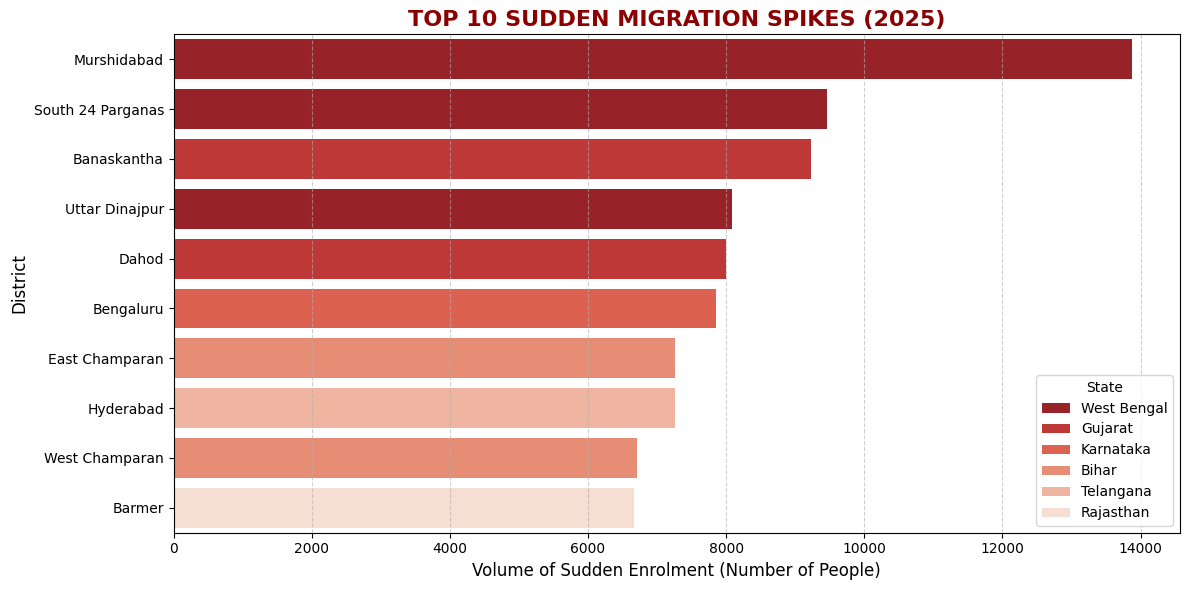

Analysis: These districts showed near-zero activity previously and suddenly exploded with enrolment.
This is the strongest signal for 'New Settlement' or 'Administrative Drive'.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the Data
try:
    df = pd.read_csv('cleaned_migration_data.csv')
    
    # 2. Pre-process (Date Format & Sorting)
    df['year_month'] = pd.to_datetime(df['year_month'])
    df = df.sort_values(by=['district', 'year_month'])
    
    # 3. Apply the Growth Logic (The Math)
    # This recreates the 'enrolment_growth' column in case it was lost
    df['prev_enrolment'] = df.groupby('district')['total_enrolment'].shift(1).fillna(0)
    df['enrolment_growth'] = ((df['total_enrolment'] - df['prev_enrolment']) / 
                              (df['prev_enrolment'] + 1)) * 100

    # 4. Save the Enhanced Data
    df.to_csv('final_migration_intelligence_data.csv', index=False)
    print("Saved enhanced data to 'final_migration_intelligence_data.csv'")

    # 5. Visualize the Top 10 Spikes
    top_10_spikes = df[df['total_enrolment'] > 50].sort_values(by='enrolment_growth', ascending=False).head(10)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=top_10_spikes, y='district', x='total_enrolment', hue='state', dodge=False, palette='Reds_r')

    plt.title('TOP 10 SUDDEN MIGRATION SPIKES (2025)', fontsize=16, fontweight='bold', color='darkred')
    plt.xlabel('Volume of Sudden Enrolment (Number of People)', fontsize=12)
    plt.ylabel('District', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.legend(title='State', loc='lower right')

    plt.tight_layout()
    plt.savefig('top_migration_spikes.png')
    plt.show()

    print("Analysis: These districts showed near-zero activity previously and suddenly exploded with enrolment.")
    print("This is the strongest signal for 'New Settlement' or 'Administrative Drive'.")

except FileNotFoundError:
    print("Error: 'cleaned_migration_data.csv' not found. Please check the file location.")
except KeyError as e:
    print(f"Error: Missing column {e}. Please check your CSV headers.")

In [2]:
# Load the enhanced data you just saved
try:
    df = pd.read_csv('final_migration_intelligence_data.csv')
    
    # Sort for Ranking
    # Metric 1: High Volume Hubs (Where are the most people going?)
    top_volume = df.sort_values(by='total_enrolment', ascending=False).head(5)
    
    # Metric 2: High Velocity Hotspots (Where is the growth fastest?)
    # We filter for >50 people to avoid noise
    top_growth = df[df['total_enrolment'] > 50].sort_values(by='enrolment_growth', ascending=False).head(5)

    print("UIDAI MIGRATION INTELLIGENCE: EXECUTIVE SUMMARY")
    print("="*60)
    
    print("\n1. HIGH VELOCITY ZONES (Sudden Spikes)")
    print("Definition: Districts with near-zero previous activity that suddenly exploded.")
    print("-" * 60)
    print(f"{'District':<20} {'State':<20} {'Inflow':<10} {'Growth Status'}")
    print("-" * 60)
    for _, row in top_growth.iterrows():
        print(f"{row['district']:<20} {row['state']:<20} {int(row['total_enrolment']):<10} CRITICAL SPIKE")

    print("\n2. HIGH VOLUME HUBS (Mass Migration)")
    print("Definition: Districts handling the highest absolute load of migrants.")
    print("-" * 60)
    print(f"{'District':<20} {'State':<20} {'Inflow':<10} {'Date'}")
    print("-" * 60)
    for _, row in top_volume.iterrows():
        print(f"{row['district']:<20} {row['state']:<20} {int(row['total_enrolment']):<10} {row['year_month']}")
        
    print("\n" + "="*60)
    print("REPORT GENERATED SUCCESSFULLY.")

except FileNotFoundError:
    print("Error: 'final_migration_intelligence_data.csv' not found. Please run the previous cell first.")

UIDAI MIGRATION INTELLIGENCE: EXECUTIVE SUMMARY

1. HIGH VELOCITY ZONES (Sudden Spikes)
Definition: Districts with near-zero previous activity that suddenly exploded.
------------------------------------------------------------
District             State                Inflow     Growth Status
------------------------------------------------------------
Murshidabad          West Bengal          13877      CRITICAL SPIKE
South 24 Parganas    West Bengal          9459       CRITICAL SPIKE
Banaskantha          Gujarat              9228       CRITICAL SPIKE
Uttar Dinajpur       West Bengal          8083       CRITICAL SPIKE
Dahod                Gujarat              8001       CRITICAL SPIKE

2. HIGH VOLUME HUBS (Mass Migration)
Definition: Districts handling the highest absolute load of migrants.
------------------------------------------------------------
District             State                Inflow     Date
------------------------------------------------------------
Murshidabad     